In [1]:
#! wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [2]:
#! unzip jena_climate_2009_2016.csv.zip

In [3]:
from util import print_curves

Using TensorFlow backend.


### Inspect Jena Weather Dataset

In [4]:
import os
import pandas as pd

data_dir = './Downloads/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
df = pd.read_csv(fname)

In [5]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


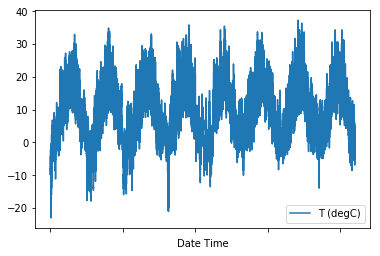

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
df.plot('Date Time','T (degC)')

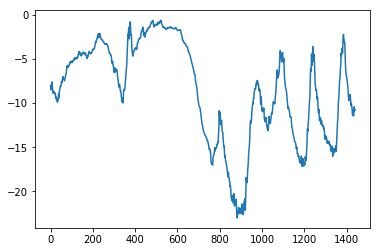

In [7]:
plt.plot(range(1440),df['T (degC)'][:1440])

### Preprocess Data

In [8]:
from sklearn import preprocessing

#df = preprocessing.scale(df.drop('Date Time', axis=1))

In [9]:
df_time = df
df = df.drop('Date Time', axis=1)

In [10]:
mean = df.mean(0)
std = df.std(0)

In [11]:
# standardize data
df = df.sub(mean, axis=1).div(std, axis=1)

In [12]:
df.std(0)

p (mbar)           1.0
T (degC)           1.0
Tpot (K)           1.0
Tdew (degC)        1.0
rh (%)             1.0
VPmax (mbar)       1.0
VPact (mbar)       1.0
VPdef (mbar)       1.0
sh (g/kg)          1.0
H2OC (mmol/mol)    1.0
rho (g/m**3)       1.0
wv (m/s)           1.0
max. wv (m/s)      1.0
wd (deg)           1.0
dtype: float64

In [13]:
df.mean(0)

p (mbar)          -3.526411e-13
T (degC)           6.469275e-15
Tpot (K)           4.183824e-13
Tdew (degC)       -1.180013e-15
rh (%)             2.505243e-14
VPmax (mbar)      -1.337905e-13
VPact (mbar)       7.613620e-15
VPdef (mbar)      -5.937364e-14
sh (g/kg)          4.250040e-14
H2OC (mmol/mol)   -4.088514e-14
rho (g/m**3)      -2.247232e-13
wv (m/s)          -2.047628e-16
max. wv (m/s)     -1.352686e-15
wd (deg)          -2.302473e-14
dtype: float64

### Create generator based on lookback, steps delay

lookback - many timesteps back the input data should go

delay - how many timesteps in the future the target should be

step - the period, in timesteps, at which you should sample data, in this case 6 for data every hour

min-index and max-index - helpful for keeping validation and testing separate

In [14]:
import numpy as np


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6,
              reverse=False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    # create offset so we don't see the same 1/step th of data in non-shuffled
    # scenario
    offset = 1

    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                # won't this reset the generator to the same place, esentially not giving us 1/6 of the data?
                # might be somewhat trivial since we're taking hourly samples,
                # so data only has changed by an hour and we're reading across
                # 8 years total dataset
                i = min_index + lookback + offset
                offset += 1
                if offset == step:
                    offset = 0
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        if reverse == True:
            yield samples[:, ::-1, :], targets
        else:
            yield samples, targets

In [15]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
num_features = df.shape[1]

Create 3 generators that look at different segments of the data

In [16]:
train_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

# how many train steps to see entire dataset
train_steps = (200000 - lookback) // batch_size

# how many val steps to see entire dataset
val_steps = (300000 - 200001 - lookback) // batch_size

# how many test steps to see entire dataset
test_steps = (len(df) - 300001 - lookback) // batch_size

# need to check if we're processing the cursor at all, i.e. are we only
# seeing 1/6 of the data since we're sampling every 6 hours
# Actually, we're shuffling, so that should take care of it, but only for
# training, in theory you want to run through 6 times, offestting,
# something like that

### Try Naive Method - Predict temp is same as 24 hours previous

In [17]:
def evaluate_naive_method():
    batch_maes = []
    # going through ALL steps was taking a long time, value is almost the same as printed
    #for step in range(val_steps):
    for step in range(500):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.abs(preds - targets)
        batch_maes.append(mae)
    return np.mean(batch_maes)

naive_mae = evaluate_naive_method()
print('naive mae: ', naive_mae)
print('Celcius Degress Error:', naive_mae * std[0])


('naive mae: ', 0.30031224152324865)
('Celcius Degress Error:', 2.5101540737249497)


So we're off by 2.54 degrees Celsius

### Try Easier MLP Method - multi GPU

In [34]:
from keras.models import Sequential
from keras.layers import Flatten, Dense


model = Sequential()
model.add(Flatten(input_shape=(lookback // step, num_features)))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
1551/1551 [==============================] - 13s 9ms/step - loss: 2.1068 - mean_absolute_error: 0.7237 - val_loss: 0.1939 - val_mean_absolute_error: 0.3477
Epoch 2/3
1551/1551 [==============================] - 14s 9ms/step - loss: 0.1344 - mean_absolute_error: 0.2866 - val_loss: 0.1732 - val_mean_absolute_error: 0.3280
Epoch 3/3
1551/1551 [==============================] - 14s 9ms/step - loss: 0.1027 - mean_absolute_error: 0.2519 - val_loss: 0.1975 - val_mean_absolute_error: 0.3541
CPU times: user 1min 11s, sys: 7.82 s, total: 1min 19s
Wall time: 41 s
Min Val MAE: 0.328047437736
Min Val Loss: 0.173184163891


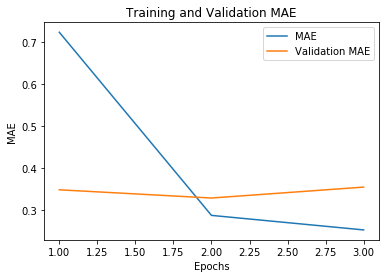

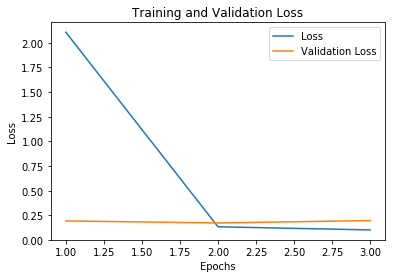

In [35]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

%time history = model.fit_generator(train_gen, epochs=3, steps_per_epoch=train_steps, validation_steps=val_steps, validation_data=val_gen)

print_curves(history)

In [32]:
import tensorflow as tf
from keras.utils import multi_gpu_model

from keras.models import Sequential
from keras.layers import Flatten, Dense

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Flatten(input_shape=(lookback // step, num_features)))
    model.add(Dense(32, activation= 'relu'))
    model.add(Dense(1))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
1551/1551 [==============================] - 19s 13ms/step - loss: 2.0235 - mean_absolute_error: 0.6917 - val_loss: 0.2114 - val_mean_absolute_error: 0.3625
Epoch 2/3
1551/1551 [==============================] - 19s 12ms/step - loss: 0.1327 - mean_absolute_error: 0.2861 - val_loss: 0.1748 - val_mean_absolute_error: 0.3304
Epoch 3/3
1551/1551 [==============================] - 19s 12ms/step - loss: 0.1044 - mean_absolute_error: 0.2537 - val_loss: 0.1771 - val_mean_absolute_error: 0.3319
CPU times: user 2min 23s, sys: 17.4 s, total: 2min 41s
Wall time: 57.7 s
Min Val MAE: 0.330429912088
Min Val Loss: 0.174796134902


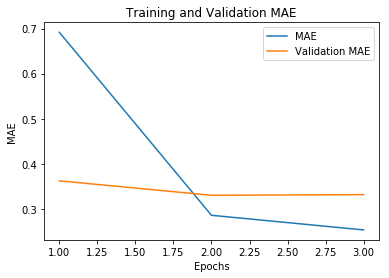

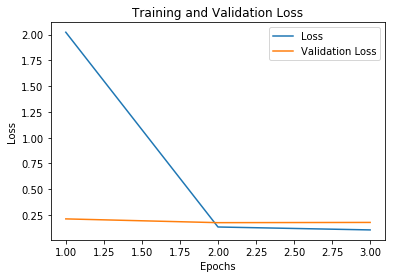

In [33]:
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

%time history = parallel_model.fit_generator(train_gen, epochs=3, steps_per_epoch=train_steps, validation_steps=val_steps, validation_data=val_gen)

print_curves(history)

Text(0,0.5,u'seconds 3 epochs')

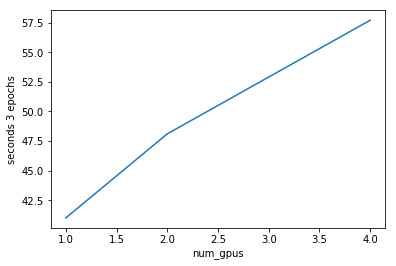

In [38]:
p100_gpus = [1, 2, 4]
times = [41, 48.1, 57.7]

plt.plot(p100_gpus, times)
plt.xlabel('num_gpus')
plt.ylabel('seconds 3 epochs')

Basically the opposite of what we want. Either it's not splitting generator or too simple of a model to benefit from parallelization.

We're not really outperforming Naive. We have large hypothesis space, but it's failing to find simple solution to simple problem.

### First Recurrent Baseline

In [39]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(32, input_shape=(lookback // step, df.shape[1])))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)
print(np.min(history.history['val_mean_absolute_error']))

Epoch 1/20
 44/500 [=>............................] - ETA: 1:50 - loss: 0.4543 - mean_absolute_error: 0.4543

KeyboardInterrupt: 

In [47]:
from keras.layers import GRU


with tf.device('/cpu:0'):
    model = Sequential()
    model.add(GRU(32, input_shape=(lookback // step, df.shape[1])))
    model.add(Dense(1))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [48]:
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = parallel_model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)
print(np.min(history.history['val_mean_absolute_error']))

Epoch 1/20
 29/500 [>.............................] - ETA: 4:14 - loss: 0.4829 - mean_absolute_error: 0.4829

KeyboardInterrupt: 

In [ ]:
best_val_mae = np.min(history.history['val_mean_absolute_error'])
print(best_val_mae)
print(best_val_mae * std[0])

Val MAE has improved quite a bit, but we're overfitting

### Add Recurrent Dropout

Need to add double the training steps more or less because of dropout

In [54]:
model = Sequential()
model.add(GRU(32,
             dropout=0.2,
             recurrent_dropout=0.2,
             # why can we do none?
             input_shape=(None, df.shape[1])))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)

Epoch 1/20
500/500 [==============================] - 204s 407ms/step - loss: 0.3580 - mean_absolute_error: 0.3580 - val_loss: 0.2895 - val_mean_absolute_error: 0.2895
Epoch 2/20
500/500 [==============================] - 191s 382ms/step - loss: 0.3324 - mean_absolute_error: 0.3324 - val_loss: 0.2879 - val_mean_absolute_error: 0.2879
Epoch 3/20
500/500 [==============================] - 202s 404ms/step - loss: 0.3274 - mean_absolute_error: 0.3274 - val_loss: 0.2853 - val_mean_absolute_error: 0.2853
Epoch 4/20
500/500 [==============================] - 196s 391ms/step - loss: 0.3218 - mean_absolute_error: 0.3218 - val_loss: 0.2817 - val_mean_absolute_error: 0.2817
Epoch 5/20
499/500 [============================>.] - ETA: 0s - loss: 0.3178 - mean_absolute_error: 0.3178

KeyboardInterrupt: 

### Stack Recurrent Layers

In [104]:
model = Sequential()
model.add(GRU(32,
             dropout=0.1,
             recurrent_dropout=0.5,
             return_sequences = True,
             # why can we do none?
             input_shape=(None, df.shape[1])))
model.add(GRU(64, activation='relu',
             dropout=0.1,
             recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 40, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)

Epoch 1/40
371/500 [=====================>........] - ETA: 1:21 - loss: 0.3482 - mean_absolute_error: 0.3482

KeyboardInterrupt: 

We have improved a little bit, but we're bottlenecking. We're no longer overfitting, so perhaps we need a larger network for larger hypothesis space.

### Bidirectional RNNs

In [126]:
train_gen_reverse = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    reverse=True)

val_gen_reverse = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size,
    reverse=True)

test_gen_reverse = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size,
    reverse=True)

In [127]:
model = Sequential()
model.add(GRU(32, input_shape=(lookback // step, df.shape[1])))
model.add(Dense(1))

model.summary()

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen_reverse, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen_reverse, validation_steps = val_steps)

print_curves(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 32)                4512      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
  8/500 [..............................] - ETA: 3:33 - loss: 0.6307 - mean_absolute_error: 0.6307

KeyboardInterrupt: 

Performs much worse, as we might be able to expect, most of the predictive power comes from the data chronologically, i.e. temperature at time t depends on t-1, whereas temp at time t does not depend on t+1

### Let's Try reverse chronological on IMDB

In [51]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Loading data...


In [68]:
from keras import layers

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

%time history_4096 = parallel_model.fit(x_train, y_train, epochs = 10, batch_size = 4096, validation_split=0.2)

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

%time history_2048 = parallel_model.fit(x_train, y_train, epochs = 10, batch_size = 2048, validation_split=0.2)


with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

%time history_1028 = parallel_model.fit(x_train, y_train, epochs = 10, batch_size = 1028, validation_split=0.2)

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

%time history_512 = parallel_model.fit(x_train, y_train, epochs = 10, batch_size = 512, validation_split=0.2)

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

%time history_256 = parallel_model.fit(x_train, y_train, epochs = 10, batch_size = 256, validation_split=0.2)

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

%time history_128 = parallel_model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split=0.2)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 654us/step - loss: 0.6900 - acc: 0.5498 - val_loss: 0.6835 - val_acc: 0.6002
Epoch 2/10
20000/20000 [==============================] - 10s 499us/step - loss: 0.6663 - acc: 0.6591 - val_loss: 0.6444 - val_acc: 0.6398
Epoch 3/10
20000/20000 [==============================] - 10s 497us/s

Epoch 9/10
20000/20000 [==============================] - 16s 812us/step - loss: 0.2686 - acc: 0.8996 - val_loss: 0.3981 - val_acc: 0.8380
Epoch 10/10
20000/20000 [==============================] - 16s 815us/step - loss: 0.2464 - acc: 0.9114 - val_loss: 0.3922 - val_acc: 0.8336
CPU times: user 8min 44s, sys: 51.2 s, total: 9min 36s
Wall time: 2min 52s
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 s

20000/20000 [==============================] - 56s 3ms/step - loss: 0.2190 - acc: 0.9203 - val_loss: 0.3993 - val_acc: 0.8430
Epoch 7/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.2035 - acc: 0.9266 - val_loss: 0.3798 - val_acc: 0.8548
Epoch 8/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.1926 - acc: 0.9312 - val_loss: 0.3759 - val_acc: 0.8756
Epoch 9/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1692 - acc: 0.9394 - val_loss: 0.4174 - val_acc: 0.8738
Epoch 10/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.1540 - acc: 0.9462 - val_loss: 0.3856 - val_acc: 0.8540
CPU times: user 30min 36s, sys: 2min 52s, total: 33min 29s
Wall time: 9min 20s
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         1280000   
________________________________________________

20000/20000 [==============================] - 201s 10ms/step - loss: 0.2599 - acc: 0.9034 - val_loss: 0.3744 - val_acc: 0.8346
Epoch 4/10
20000/20000 [==============================] - 205s 10ms/step - loss: 0.2251 - acc: 0.9178 - val_loss: 0.3155 - val_acc: 0.8736
Epoch 5/10
20000/20000 [==============================] - 200s 10ms/step - loss: 0.1928 - acc: 0.9345 - val_loss: 0.3606 - val_acc: 0.8724
Epoch 6/10
20000/20000 [==============================] - 200s 10ms/step - loss: 0.1705 - acc: 0.9408 - val_loss: 0.3617 - val_acc: 0.8668
Epoch 7/10
20000/20000 [==============================] - 199s 10ms/step - loss: 0.1563 - acc: 0.9461 - val_loss: 0.4742 - val_acc: 0.8446
Epoch 8/10
20000/20000 [==============================] - 199s 10ms/step - loss: 0.1404 - acc: 0.9525 - val_loss: 0.5446 - val_acc: 0.8434
Epoch 9/10
20000/20000 [==============================] - 198s 10ms/step - loss: 0.1247 - acc: 0.9571 - val_loss: 0.5461 - val_acc: 0.8356
Epoch 10/10
20000/20000 [=============

In [103]:
from keras.optimizers import RMSprop

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)



parallel_model.compile(optimizer=RMSprop(lr=0.01, decay=0.1), loss='binary_crossentropy', metrics=['acc'])

%time history_4096 = parallel_model.fit(x_train, y_train, epochs = 30, batch_size = 4096, validation_split=0.2)

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    
parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(optimizer=RMSprop(lr=0.01, decay=0.1), loss='binary_crossentropy', metrics=['acc'])

%time history_2048 = parallel_model.fit(x_train, y_train, epochs = 30, batch_size = 2048, validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 16s 788us/step - loss: 0.6812 - acc: 0.5454 - val_loss: 0.6725 - val_acc: 0.5610
Epoch 2/30
20000/20000 [==============================] - 9s 460us/step - loss: 0.6234 - acc: 0.6546 - val_loss: 0.6292 - val_acc: 0.6470
Epoch 3/30
20000/20000 [==============================] - 9s 463us/ste

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.7243 - acc: 0.5595 - val_loss: 0.6665 - val_acc: 0.6386
Epoch 2/30
20000/20000 [==============================] - 16s 784us/step - loss: 0.5837 - acc: 0.7103 - val_loss: 0.5808 - val_acc: 0.7118
Epoch 3/30
20000/20000 [==============================] - 16s 788us/step - loss: 0.4936 - acc: 0.7719 - val_loss: 0.4967 - val_acc: 0.7746
Epoch 4/30
20000/20000 [==============================] - 15s 771us/step - loss: 0.3996 - acc: 0.8364 - val_loss: 0.4627 - val_acc: 0.7982
Epoch 5/30
20000/20000 [==============================] - 16s 782us/step - loss: 0.3663 - acc: 0.8541 - val_loss: 0.4508 - val_acc: 0.8098
Epoch 6/30
20000/20000 [==============================] - 16s 780us/step - loss: 0.3281 - acc: 0.8724 - val_loss: 0.4326 - val_acc: 0.8246
Epoch 7/30
20000/20000 [==============================] - 16s 782us/step - loss: 0.3034 - acc: 0.8851 - val_loss: 0.434

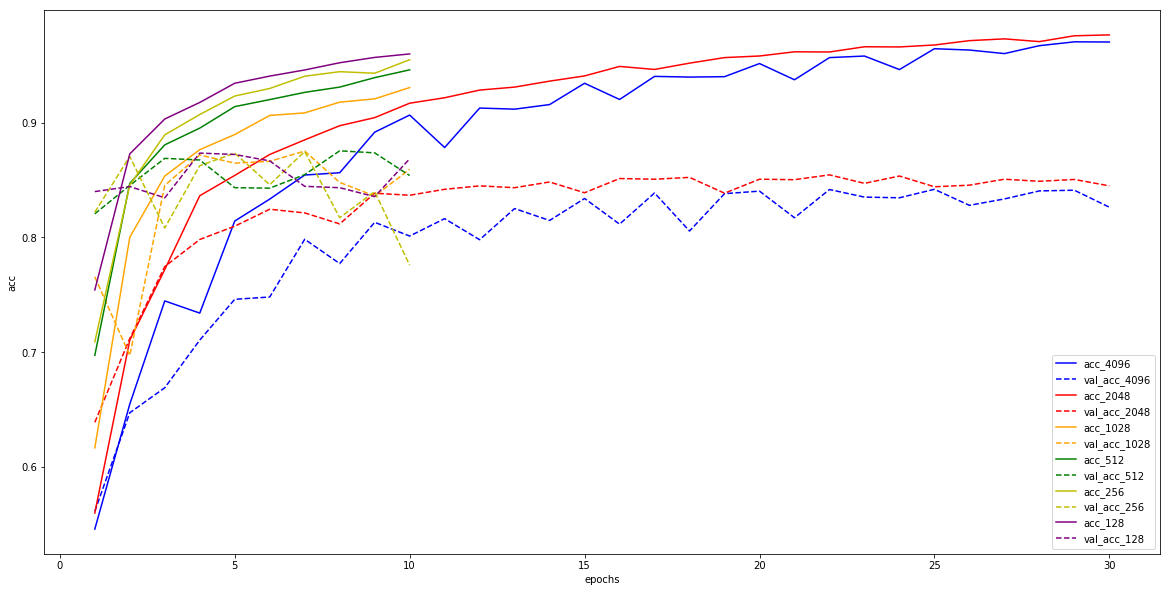

In [104]:
epochs = range(1, 10+1)
epochs_30 = range(1, 30+1)
plt.clf()

plt.figure(figsize=(20,10)) 
plt.plot(epochs_30, history_4096.history['acc'], 'b', label='acc_4096')
plt.plot(epochs_30, history_4096.history['val_acc'], 'b--', label='val_acc_4096')

plt.plot(epochs_30, history_2048.history['acc'], 'r', label='acc_2048')
plt.plot(epochs_30, history_2048.history['val_acc'], 'r--', label='val_acc_2048')

plt.plot(epochs, history_1028.history['acc'], '-', color='orange', label='acc_1028')
plt.plot(epochs, history_1028.history['val_acc'], '--', color='orange', label='val_acc_1028')

plt.plot(epochs, history_512.history['acc'], 'g-', label='acc_512')
plt.plot(epochs, history_512.history['val_acc'], 'g--', label='val_acc_512')

plt.plot(epochs, history_256.history['acc'], 'y-', label='acc_256')
plt.plot(epochs, history_256.history['val_acc'], 'y--', label='val_acc_256')

plt.plot(epochs, history_128.history['acc'], '-', color='purple', label='acc_128')
plt.plot(epochs, history_128.history['val_acc'], '--', color='purple', label='val_acc_128')



plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()


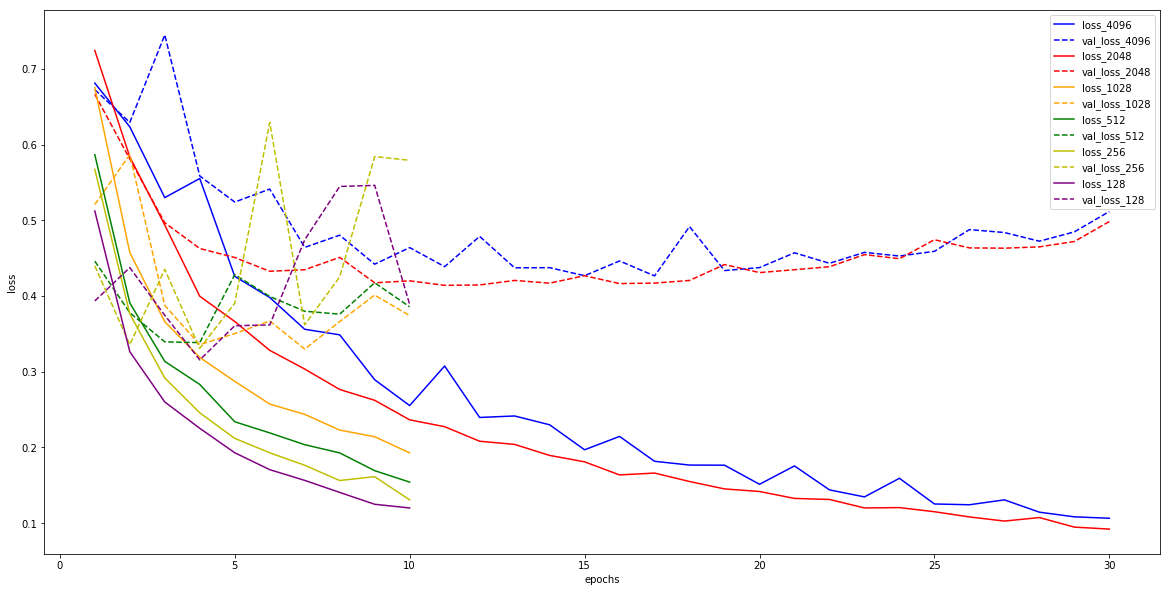

In [105]:
epochs = range(1, 10+1)
epochs_30 = range(1, 30+1)
plt.clf()

plt.figure(figsize=(20,10)) 
plt.plot(epochs_30, history_4096.history['loss'], 'b', label='loss_4096')
plt.plot(epochs_30, history_4096.history['val_loss'], 'b--', label='val_loss_4096')

plt.plot(epochs_30, history_2048.history['loss'], 'r', label='loss_2048')
plt.plot(epochs_30, history_2048.history['val_loss'], 'r--', label='val_loss_2048')

plt.plot(epochs, history_1028.history['loss'], '-', color='orange', label='loss_1028')
plt.plot(epochs, history_1028.history['val_loss'], '--', color='orange', label='val_loss_1028')

plt.plot(epochs, history_512.history['loss'], 'g-', label='loss_512')
plt.plot(epochs, history_512.history['val_loss'], 'g--', label='val_loss_512')

plt.plot(epochs, history_256.history['loss'], 'y-', label='loss_256')
plt.plot(epochs, history_256.history['val_loss'], 'y--', label='val_loss_256')

plt.plot(epochs, history_128.history['loss'], '-', color='purple', label='loss_128')
plt.plot(epochs, history_128.history['val_loss'], '--', color='purple', label='val_loss_128')



plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()